In [1]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt
import itertools

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

Define the terms
$$
\vec\lambda, \kappa, K \equiv |\kappa|, \vec \omega
$$
Where $\vec \lambda$ is a list of the coefficients, $\kappa$ is the set of Pauli operators in the model, $K$ is the order of this set, and $\vec \omega$ is the transformed product-form coefficients in the noise model (Eq. S9)

In [8]:
print([''.join(x) for x in itertools.product(pauli_alphabet, repeat=n)])

['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']


In [10]:
n = 2 #Number of qubits (Later specify processor topology)
model_paulis = PauliList(['II', 'IX','IY','IZ','XI','YI','ZI'])
pauli_alphabet = ['I','X','Y','Z']
pauli_list = PauliList([''.join(x) for x in itertools.product(pauli_alphabet, repeat=n)]) #Kappa
K = len(model_paulis) #K = |Kappa|
coeffs = rand(K)
print(coeffs)

[0.44918518 0.80053815 0.09152435 0.52393085 0.56607658 0.32020915
 0.5714239 ]


Eq. S9: $\omega_k = \frac{1}{2}(1+e^{-2\lambda_k})$

In [73]:
omegas = []
for (k, lambdak) in enumerate(coeffs):
    omegas.append(.5*(1+math.exp(-2*lambdak)))

Defining the simplectic inner product, a piecewise function such that
$$
\langle P_a, P_b \rangle_{sp} = 
\begin{cases}
0 & [P_a, P_b] = 0 \\
1 & \text{else}
\end{cases}
$$
This is expressed in a matrix $M_{ab} = \langle P_a, P_b \rangle_{sp}$ to simplify equation (S10)

In [11]:
def s_prod(a, b):
    if(a.compose(b) == b.compose(a)):
        return 0
    else:
        return 1

M = np.zeros([len(pauli_list), K])
for (i,a) in enumerate(pauli_list):
    for (j,b) in enumerate(model_paulis):
        M[i,j] = s_prod(a,b)

ideal_fidelities is the ideal $\vec f$ (with components $f_a$) giving the fidelities for each element in `pauli_list`. This is computed using Eq. (S11),
$$
-\log(\vec f)/2 = M\vec \lambda
$$

In [75]:
ideal_fidelities = np.exp(-2*np.dot(M, coeffs))
print(ideal_fidelities)

[1.       1.       0.998002 0.998002]


The model fidelities can be converted to Pauli coefficients using the simplectic Hadamard transformation,
$$
c_b = \frac{1}{2^n} \sum_a (-1)^{\langle P_a, P_b\rangle_{sp}}f_a
$$
These convert the diagonal transfer matrix to a diagonal $\chi$ matrix. This seems to fail for some models, I wonder why? There is also something wrong with the normalization

In [76]:
#What are the requirements for this to work? 
#How many of the fidelities need to be measured?
def WHtransform(b, ideal_fidelities, pauli_list):
    c_b = 0
    P_b = pauli_list[b]
    for (f_a, P_a) in zip(ideal_fidelities, pauli_list):
        c_b += (-1)**s_prod(P_a, P_b)*f_a
    c_b /= 4**n
    return c_b

chi = []
for b in range(K):
    chi.append(WHtransform(b, ideal_fidelities, pauli_list))
    
print(chi)

[0.9990009993336666, 0.0009990006663334328, 0.0, 0.0]


Use the resulting diagonal process matrix to create a pauli channel
$$
\Lambda(\rho) = \sum_{i}\chi_i P_i \rho P_i
$$

In [77]:
#Pauli error channel
pauli_error_channel = pauli_error(zip(pauli_list, chi))
pauli_noise_model = NoiseModel()
pauli_noise_model.add_all_qubit_quantum_error(pauli_error_channel, ['id', 'rz', 'sx'])
pauli_basis_gates = pauli_noise_model.basis_gates

This is an alternative expression of the noise model through Kraus operators according to Eq. (1):
$$
\Lambda(\rho) = \prod_{k \in \kappa} \left(\omega_k \rho + P_k \rho P_k\right)
$$
where the product symbol denotes composition

In [78]:
#Build list of Kraus Operators
kraus_ops = Kraus(np.identity(2**n))
for (P,omega,lambdak) in zip(pauli_list, omegas, coeffs):
   if lambdak != 0:
        op = Kraus([P.to_matrix()*np.sqrt(1-omega),np.sqrt(omega)*np.identity(2**n)])
        kraus_ops = kraus_ops.compose(op)

In [79]:
#Kraus error channel
kraus_error_channel = kraus_error(kraus_ops.data)
kraus_noise_model = NoiseModel()
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rz', 'sx', 'h'])
kraus_basis_gates = kraus_noise_model.basis_gates

I'm not sure whether the noise is dependent on the specific gates enacted. In the literature, it is written $\tilde{\mathcal{U}} = \mathcal{U} \circ \Lambda$, but is $\Lambda$ dependent on $\mathcal{U}$?

The pauli operators are diagonalizable in terms of their eigenvectors:
$$
P_a = \sum_{\vert\psi\rangle \in E_{a}(+1)} \vert\psi\rangle \langle\psi\vert - \sum_{\vert\psi\rangle\in E_a(-1)} \vert\psi\rangle\langle\psi\vert
$$
Take $X$ for example:
$$
\begin{align}
\text{Tr}[X\Lambda(X)] &= \text{Tr}[X\Lambda(\vert+\rangle\langle+\vert-\vert-\rangle \langle -\vert)]\\
&= \text{Tr}[X\Lambda(\vert+\rangle\langle+\vert)]+\text{Tr}[X\Lambda(\vert-\rangle\langle -\vert)]
\end{align}
$$

For $X$ estimation

In [80]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
backend = Aer.get_backend('qasm_simulator')

In [81]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("0")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("1")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [82]:
fidelities = []
expectations = [0,0]
shots = 4096
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
zfidelities = fidelities.copy()

In [83]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("+")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.h(0)
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("-")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    qc.h(0)
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [84]:
fidelities = []
expectations = [0,0]
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
xfidelities = fidelities.copy()

In [85]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("r")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.sdg(0)
    qc.h(0)
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("l")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
        
    qc.sdg(0)
    qc.h(0)
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [86]:
fidelities = []
expectations = [0,0]
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
yfidelities = fidelities.copy()

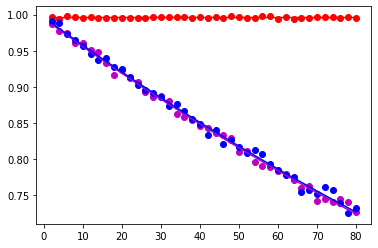

In [87]:
xrange = np.multiply(2,range(1,1+folds)) 

plt.plot(xrange, xfidelities, 'ro')
plt.plot(xrange, yfidelities, 'mo')
plt.plot(xrange, zfidelities, 'bo')

#perform optimized fit to extrapolate to the the single-gate noise limit


#do they decay to zero over time?
def Exp(t, b, a):
    return a*np.exp(-t * b)

p0 = (.05, 1)
params, cv = scipy.optimize.curve_fit(Exp, xrange, xfidelities, p0)
bx, ax = params
plt.plot(xrange, ax*np.exp(np.multiply(-1*bx, xrange)), 'r')

params, cv = scipy.optimize.curve_fit(Exp, xrange, yfidelities, p0)
by, ay = params
plt.plot(xrange, ay*np.exp(np.multiply(-1*by, xrange)), 'm')

params, cv = scipy.optimize.curve_fit(Exp, xrange, zfidelities, p0)
bz, az = params
plt.plot(xrange, az*np.exp(np.multiply(-1*bz, xrange)), 'b');

I don't know how to get rid of Spam errors here. I assumed that SPAM errors would dominate with no folding, so setting the exponential curve to intersect the axis at one and computing the fidelity at half of a fold gave me the final value. What should I do in this situation?

In [88]:
measured_fidelities = [1, math.exp(-bx), math.exp(-by), math.exp(-bz)]
print(measured_fidelities)
print(ideal_fidelities)

[1, 1.0000002085494388, 0.9960397684063875, 0.9960640293235287]
[1.       1.       0.998002 0.998002]


Now, the coefficients in the Lindbladian are reconstructed using the sparse model

In [89]:
def lsq_fit(coeffs):
    return np.sum(np.dot(M,coeffs)+np.log(measured_fidelities)/2)

coeffs_guess = scipy.optimize.nnls(M, -.5*np.log(measured_fidelities))

#Compare guess to the actual values
print(coeffs_guess[0])
print(coeffs)

[0.         0.00197796]
[1, 0.001]
